# Introduction to JumpStart - Text Embedding

---
Welcome to Amazon [SageMaker JumpStart](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html)! You can use JumpStart to solve many Machine Learning tasks through one-click in SageMaker Studio, or through [SageMaker JumpStart API](https://sagemaker.readthedocs.io/en/stable/overview.html#use-prebuilt-models-with-sagemaker-jumpstart). 

In this demo notebook, we demonstrate how to use the JumpStart API for Text Embedding. Text Embedding is the task of converting text into meaningful vector representations. We show how to use pre-trained model to find text embeddings. Additionally, we also show how to leverage these embeddings for Semantic Textual Similarity.

---

1. [Set Up](#1.-Set-Up)
2. [Select a model](#2.-Select-a-model)
3. [Retrieve JumpStart Artifacts & Deploy an Endpoint](#3.-Retrieve-JumpStart-Artifacts-&-Deploy-an-Endpoint)
4. [Query endpoint and parse response](#4.-Query-endpoint-and-parse-response)
5. [Semantic Textual Similarity](#5.-Semantic-Textual-Similarity)
6. [Clean up the endpoint](#6.-Clean-up-the-endpoint)

Note: This notebook was tested in Amazon SageMaker Studio on ml.t3.medium instance with Python 3 (Data Science) kernel.


### 1. Set Up

---
Before executing the notebook, there are some initial steps required for set up. This notebook requires latest version of sagemaker and ipywidgets

---

In [ ]:
!pip install sagemaker ipywidgets --upgrade --quiet

#### Permissions and environment variables

---
To host on Amazon SageMaker, we need to set up and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook as the AWS account role with SageMaker access. 

---

In [3]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

### 2. Select a model

***
Here, we download jumpstart model_manifest file from the jumpstart s3 bucket, filter-out all the Text Embedding models and select a model for inference. 
***

In [5]:
from ipywidgets import Dropdown

# download JumpStart model_manifest file.
boto3.client("s3").download_file(
    f"jumpstart-cache-prod-{aws_region}", "models_manifest.json", "models_manifest.json"
)
with open("models_manifest.json", "rb") as json_file:
    model_list = json.load(json_file)

# filter-out all the Text Embedding models from the manifest list.
text_embedding_models = []
for model in model_list:
    model_id = model["model_id"]
    if "-tcembedding-" in model_id and model_id not in text_embedding_models:
        text_embedding_models.append(model_id)

# display the model-ids in a dropdown to select a model for inference.
model_dropdown = Dropdown(
    options=text_embedding_models,
    value="tensorflow-tcembedding-bert-en-uncased-L-10-H-128-A-2-2",
    description="Select a model",
    style={"description_width": "initial"},
    layout={"width": "max-content"},
)

#### Chose a model for Inference

In [6]:
display(model_dropdown)

Dropdown(description='Select a model', index=4, layout=Layout(width='max-content'), options=('mxnet-tcembeddin…

In [7]:
# model_version="*" fetches the latest version of the model
model_id, model_version = model_dropdown.value, "*"

### 3. Retrieve JumpStart Artifacts & Deploy an Endpoint

***

We start by retrieving the `deploy_image_uri`, `deploy_source_uri`, and `model_uri` for the pre-trained model. To host the pre-trained model, we create an instance of [`sagemaker.model.Model`](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html) and deploy it. This may take a few minutes.
***

In [8]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base


endpoint_name = name_from_base(f"jumpstart-example-infer-{model_id}")

inference_instance_type = "ml.p2.xlarge"

# Retrieve the inference docker container uri. This is the base Tensorflow container image for the default model above.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)

# Retrieve the inference script uri. This includes all dependencies and scripts for model loading, inference handling etc.
deploy_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope="inference"
)


# Retrieve the model uri. This includes the model and model parameters.
model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="inference"
)


# Create the SageMaker model instance
model = Model(
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    model_data=model_uri,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name,
)

# deploy the Model. Note that we need to pass Predictor class when we deploy model through Model class,
# for being able to run inference through the sagemaker API.
model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
)

--------!

### 4. Query endpoint and parse response

---
Input to the endpoint is any string of text dumped in json and encoded in `utf-8` format. Output of the endpoint is a `json` with the text embedding.

---

In [9]:
def query(model_predictor, text):
    """Query the model predictor."""

    encoded_text = json.dumps(text).encode("utf-8")

    query_response = model_predictor.predict(
        encoded_text,
        {
            "ContentType": "application/x-text",
            "Accept": "application/json",
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return the embedding."""

    model_predictions = json.loads(query_response)
    translation_text = model_predictions["embedding"]
    return translation_text

---
Below, we  put in some example input text. You can put in any text and the model will summarize the text.

---

In [12]:
newline, bold, unbold = "\n", "\033[1m", "\033[0m"

input_text = "astonishing ... ( frames ) profound ethical and philosophical questions in the form of dazzling pop entertainment"


query_response = query(model_predictor, input_text)

embedding = parse_response(query_response)

print(
    f"{bold}Inference{unbold}:{newline}"
    f"{bold}Input text sentence{unbold}: '{input_text}'{newline}"
    f"{bold}The first 5 elements of sentence embedding{unbold}: {embedding[:5]}{newline}"
    f"{bold}Sentence embedding size{unbold}: {len(embedding)}{newline}"
)

### 5. Semantic Textual Similarity

A use case of sentence embedding is to cluster together sentences with similar semantic meaning.  In the example below we compute the embeddings of sentences in three categories: pets, cities in the U.S., and color.  We see that sentences originating from the same category have much closer embedding vectors than those from different categories.  

Specifically, the code will do the following:
* The endpoint that you have created above will output an embedding vector for each sentence;  
* The distance between any pair of sentences is computed by the cosine similarity of corresponded embedding vectors;
* A heatmap is created to visualize the distance between any pair of sentences in the embedding space. Darker the color, larger the cosine similarity (smaller the distance). 

Note. Cosine similarity of two vectors is  the inner product of the normalized vectors (scale down to have length 1).

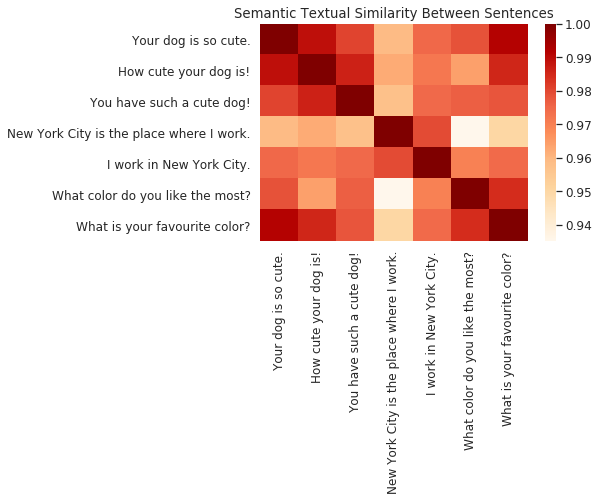

In [19]:
from sklearn.preprocessing import normalize
import numpy as np
import seaborn as sns


def plot_similarity_heatmap(text_labels, embeddings, rotation):
    """Takes sentences, embeddings and rotation as input and plot similarity heat map.

    Args:
      text_labels: a list of sentences to compute semantic textual similarity search.
      embeddings: a list of embedding vectors, each of which corresponds to a sentence.
      rotation: rotation used for display of the text_labels.
    """
    inner_product = np.inner(embeddings, embeddings)
    sns.set(font_scale=1.1)
    graph = sns.heatmap(
        inner_product,
        xticklabels=text_labels,
        yticklabels=text_labels,
        vmin=np.min(inner_product),
        vmax=1,
        cmap="OrRd",
    )
    graph.set_xticklabels(text_labels, rotation=rotation)
    graph.set_title("Semantic Textual Similarity Between Sentences")


sentences = [
    # Pets
    "Your dog is so cute.",
    "How cute your dog is!",
    "You have such a cute dog!",
    # Cities in the US
    "New York City is the place where I work.",
    "I work in New York City.",
    # Color
    "What color do you like the most?",
    "What is your favourite color?",
]

embeddings = []

for sentence in sentences:
    query_response = query(model_predictor, sentence)
    embedding = parse_response(query_response)
    embeddings.append(embedding)

embeddings = normalize(np.array(embeddings), axis=1)  # normalization before inner product
plot_similarity_heatmap(sentences, embeddings, 90)

### 6. Clean up the endpoint

In [20]:
# Delete the SageMaker endpoint
model_predictor.delete_model()
model_predictor.delete_endpoint()